In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from collections import defaultdict

C:\Users\alex_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
# Loading pre-trained BERT model and tokenizer

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    output_attentions=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [4]:
def tokenize_data(data):
    texts = data['text']
    labels = data['label']
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
    return encodings, labels

In [5]:
# Loading dataset

dataset = load_dataset("imdb")
train_data, test_data = dataset['train'], dataset['test']

In [6]:
# Prepare datasets
SUBSET_SIZE = 2000
TEST_SIZE = 500

train_data = dataset['train'].shuffle(seed=42).select(range(SUBSET_SIZE))
test_data = dataset['test'].shuffle(seed=42).select(range(TEST_SIZE))

train_encodings, train_labels = tokenize_data(train_data)
test_encodings, test_labels = tokenize_data(test_data)

train_dataset = IMDBDataset(train_encodings, train_labels)
test_dataset = IMDBDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
def train_model(model, train_loader, optimizer, loss_fn, epochs=1):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
        
        for batch in progress_bar:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        print(f'Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}')

def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

In [9]:
train_model(model, train_loader, optimizer, loss_fn, epochs=1)

Epoch 1: 100%|██████████| 125/125 [25:44<00:00, 12.36s/it, loss=0.342] 

Epoch 1, Average Loss: 0.4619352239370346


In [10]:
test_accuracy = evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 32/32 [02:03<00:00,  3.85s/it]

Test Accuracy: 0.8760


## Attention Rollout

In [11]:
def get_attentions(text):
    inputs = tokenizer(text, return_tensors="pt")
    
    outputs = model(**inputs)
    attentions = outputs.attentions

    return attentions, inputs["input_ids"]


In [12]:
def attention_rollout(attentions, input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    cumulative_attention = torch.eye(len(tokens))

    for layer_attention in attentions:
        avg_attention = layer_attention.mean(dim=1).squeeze(0)
        avg_attention += torch.eye(avg_attention.size(0))
        avg_attention /= avg_attention.sum(dim=-1, keepdim=True)
        cumulative_attention = torch.matmul(avg_attention, cumulative_attention)

    cumulative_attention = cumulative_attention.detach().numpy()

    token_to_indices = defaultdict(list)
    for idx, token in enumerate(tokens):
        if token not in ['[PAD]', '[SEP]', '[CLS]']:
            token_to_indices[token].append(idx)

    unique_tokens = list(token_to_indices.keys())
    aggregated_attention = np.zeros((len(unique_tokens), len(unique_tokens)))

    for i, token_i in enumerate(unique_tokens):
        indices_i = token_to_indices[token_i]
        for j, token_j in enumerate(unique_tokens):
            indices_j = token_to_indices[token_j]
            aggregated_attention[i, j] = cumulative_attention[np.ix_(indices_i, indices_j)].mean()

    aggregated_attention = aggregated_attention / aggregated_attention.sum(axis=1, keepdims=True)

    return aggregated_attention, unique_tokens

In [20]:
def explain_batch(reviews, labels, tokenizer, model, device='cpu', max_length=512):
    model.to(device)
    model.eval()
    
    explanations = []
    
    for review, label in zip(reviews, labels):
        # Tokenize input
        inputs = tokenizer(
            review, 
            return_tensors="pt", 
            truncation=True, 
            max_length=max_length,
            padding='max_length'
        ).to(device)
        
        # Get model outputs
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            attentions = outputs.attentions
        
        # Get prediction probabilities using softmax
        probs = torch.nn.functional.softmax(logits, dim=-1).squeeze(0)
        prediction = torch.argmax(logits).item()
        predicted_sentiment = "positive" if prediction == 1 else "negative"
        true_sentiment = "positive" if label == 1 else "negative"
        
        # Use the modified attention rollout to merge subwords
        rollout, merged_tokens = attention_rollout(attentions, inputs['input_ids'], tokenizer)
        
        # Get attention scores from [CLS] to each token
        cls_attention = rollout[0]  # First row: attention from [CLS]
        attention_scores = cls_attention[1:]  # Skip [CLS] token itself if not merged with others
        
        # Normalize scores
        attention_scores = np.array(attention_scores)
        attention_scores = attention_scores / attention_scores.sum()
        
        explanations.append({
            'text': review,
            'tokens': merged_tokens[1:],  # Skip [CLS] token
            'attention_scores': attention_scores,
            'predicted_sentiment': predicted_sentiment,
            'true_sentiment': true_sentiment,
            'correct': prediction == label,
            'pos_prob': probs[1].item(),
            'neg_prob': probs[0].item()
        })
    
    return explanations


In [21]:
def visualize_attention(explanation, top_k=10):

    # Extract data from explanation
    tokens = explanation['tokens']
    attention_scores = explanation['attention_scores']
    predicted_sentiment = explanation['predicted_sentiment']
    true_sentiment = explanation['true_sentiment']
    correct = explanation['correct']
    pos_prob = explanation['pos_prob']
    neg_prob = explanation['neg_prob']
    
    # Combine tokens with their attention scores
    word_impacts = list(zip(tokens, attention_scores))
    
    # Sort tokens by attention score (most important first)
    word_impacts.sort(key=lambda x: x[1], reverse=True)
    
    # Get top k words (handle if fewer than k tokens)
    top_k = min(top_k, len(word_impacts))
    top_words = [x[0] for x in word_impacts[:top_k]]
    top_scores = [x[1] for x in word_impacts[:top_k]]
    
    # Create horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(top_k), top_scores, align='center', color='skyblue')
    plt.yticks(range(top_k), top_words)
    plt.xlabel('Normalized Attention Score')
    plt.gca().invert_yaxis()
    plt.title(
        f"Top {top_k} Important Words\n"
        f"Predicted: {predicted_sentiment} (P={pos_prob:.2f}, N={neg_prob:.2f}) | "
        f"True: {true_sentiment} | Correct: {correct}"
    )
    
    # Add value labels to bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
                 ha='left', va='center')
    
    plt.tight_layout()
    plt.show()


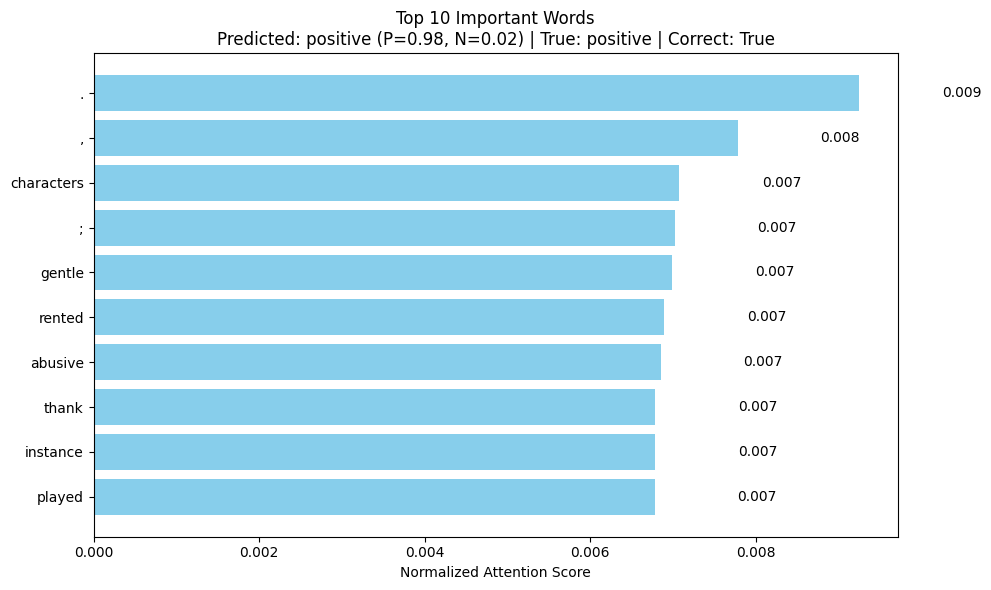

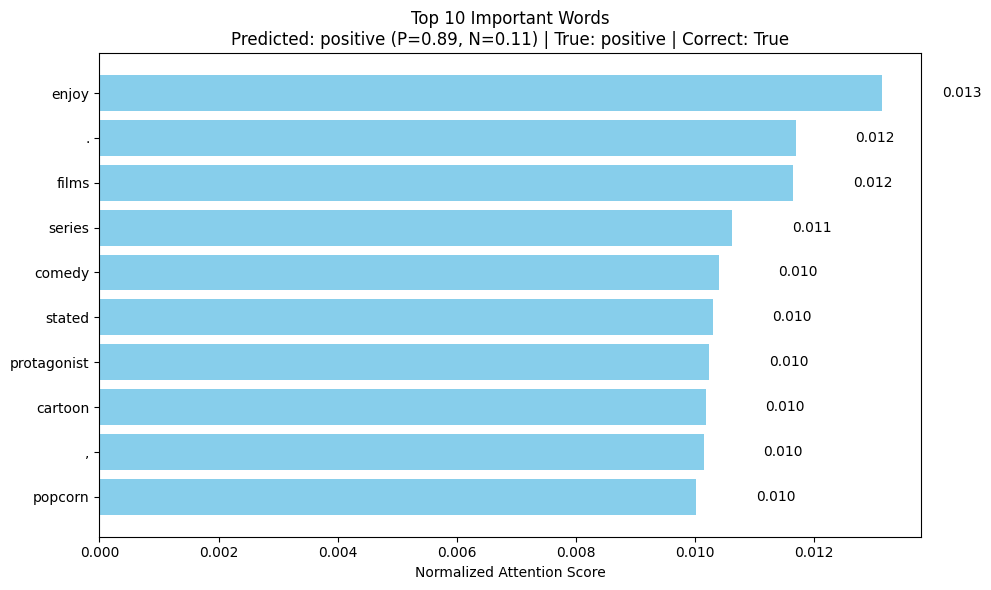

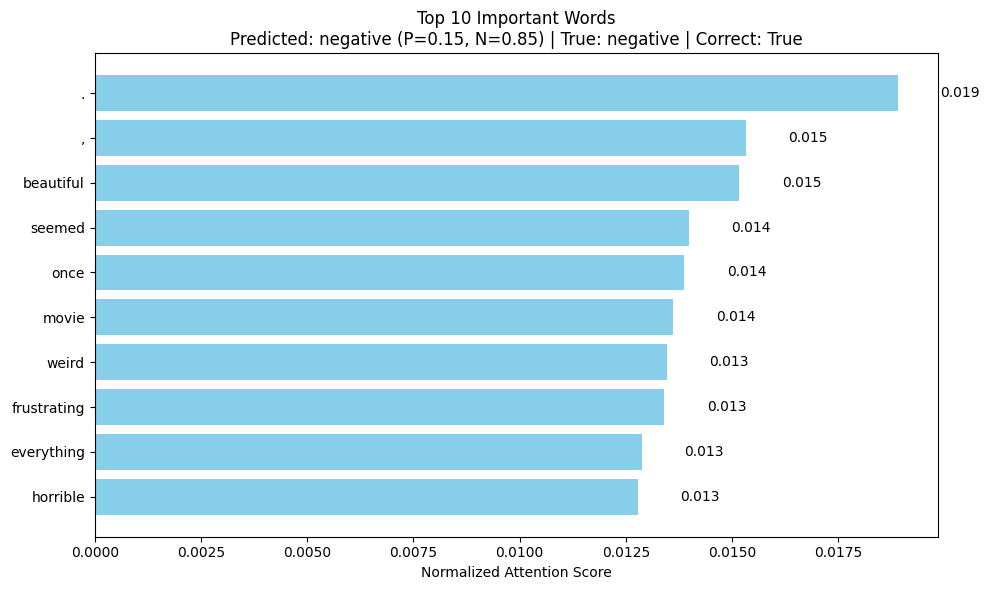

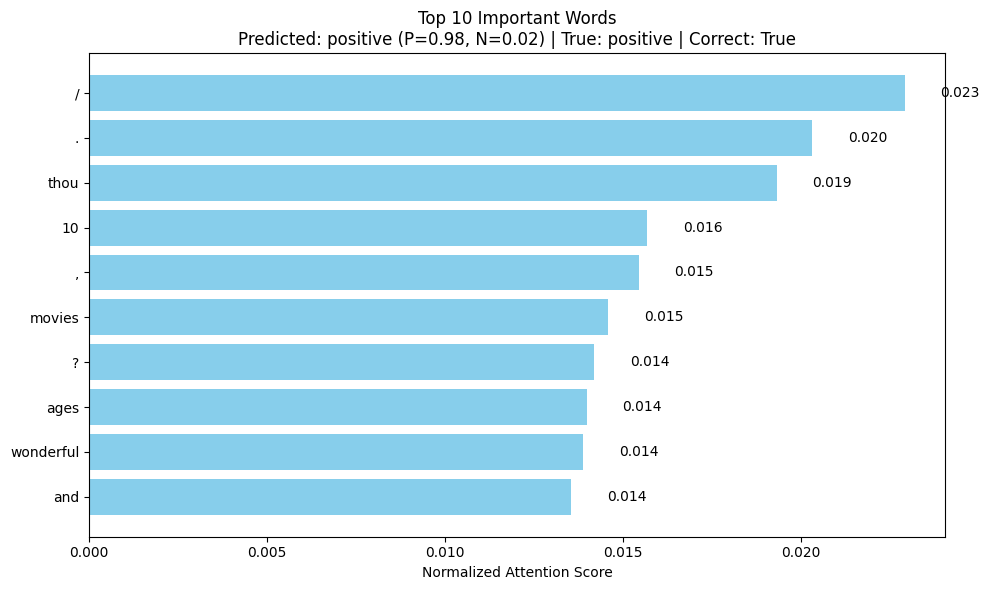

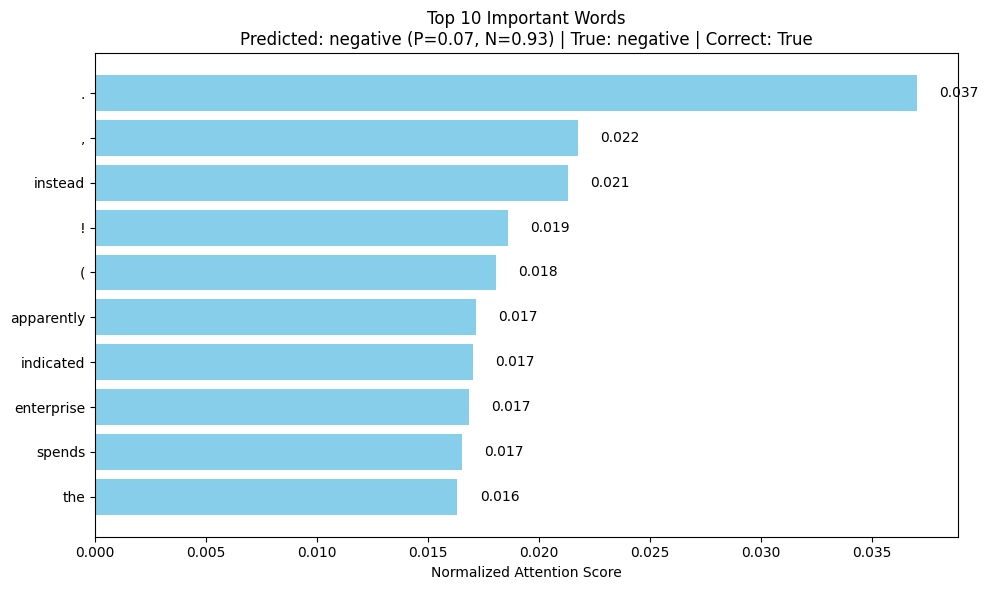

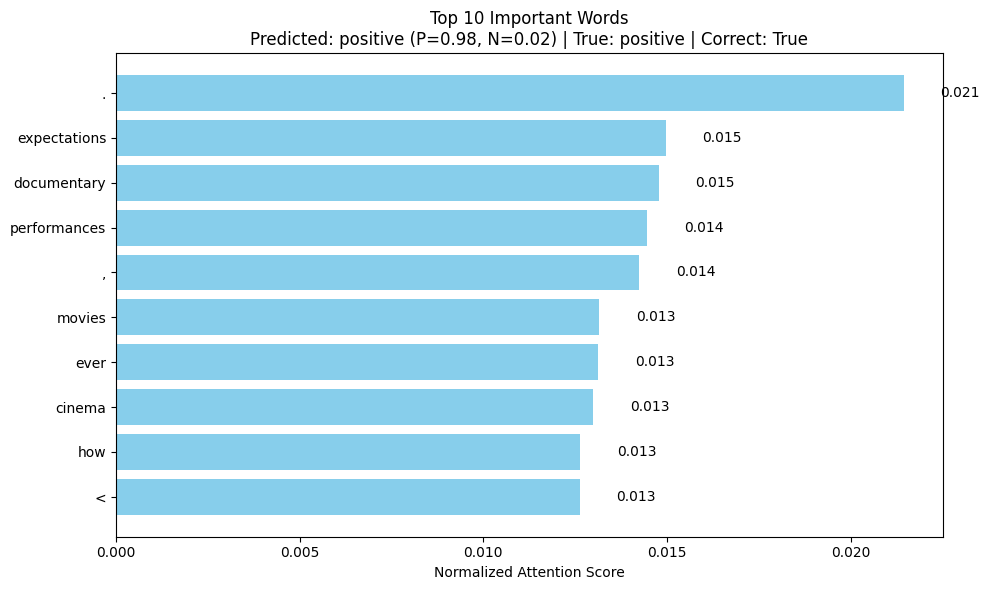

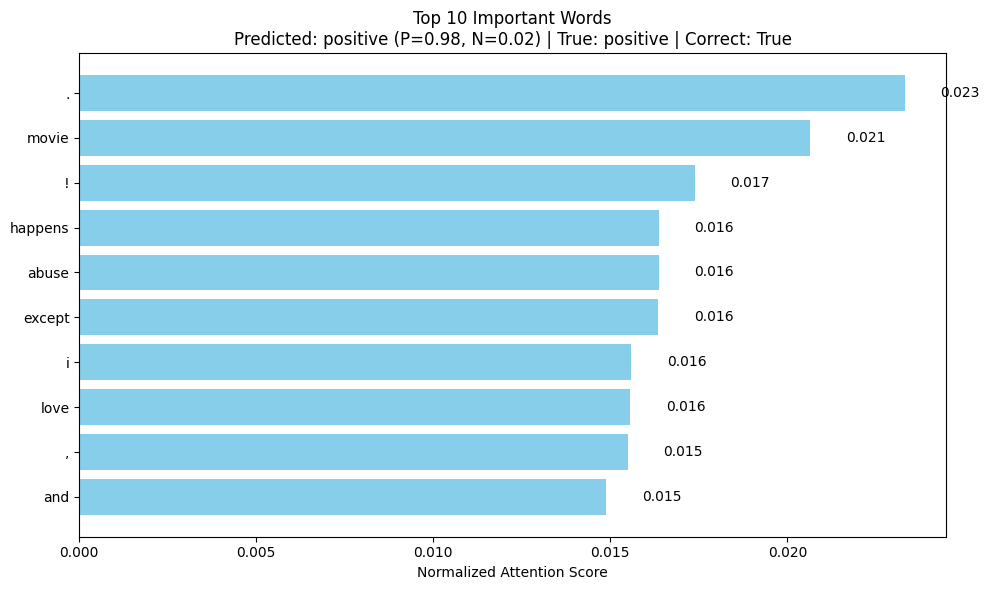

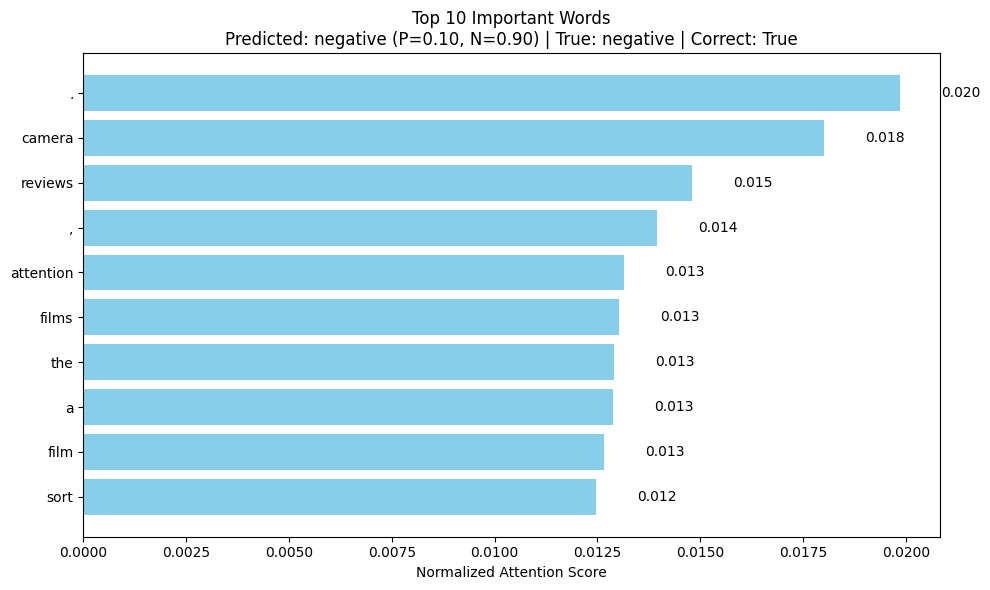

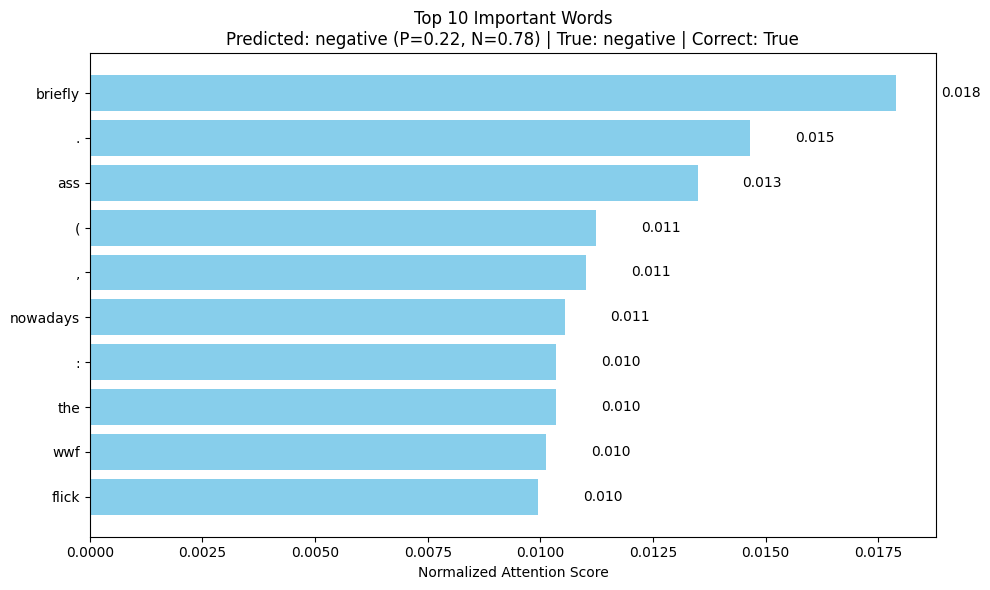

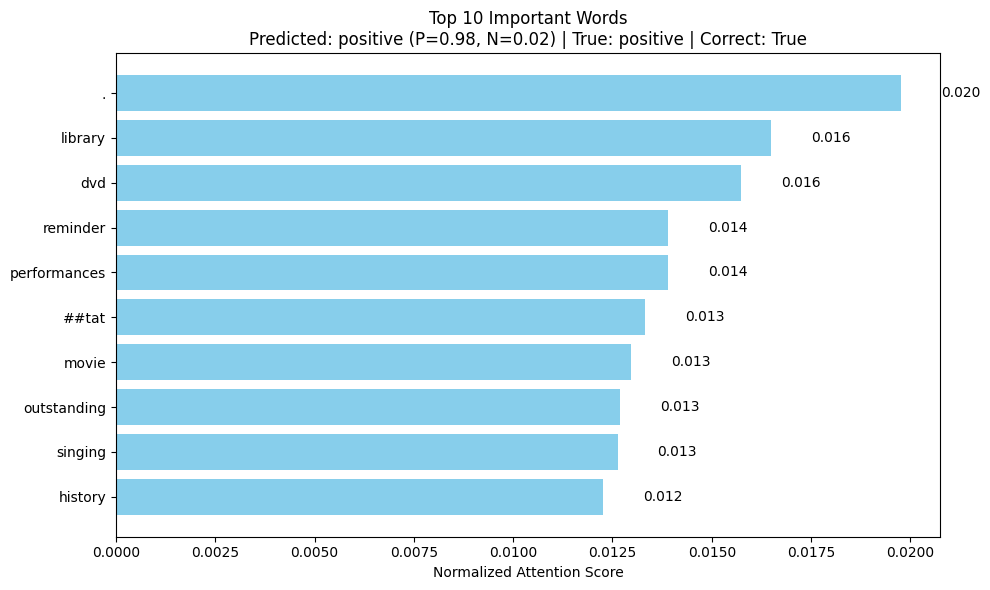

In [22]:
sample_size = 10

# Get a sample from test set
sample_reviews = test_data['text'][:sample_size]
sample_labels = test_data['label'][:sample_size]

# Explain predictions
explanations = explain_batch(sample_reviews, sample_labels, tokenizer, model)

# Visualize each explanation
for explanation in explanations:
    visualize_attention(explanation)